In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805894 sha256=48ab39663a98560ea2a95513c1f15f5af9c6cc66167cce599b1bfeaffc87ee3b
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
# start spark session and configureation
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("dat").getOrCreate()
sc = spark.sparkContext
#create an instance of SQLContext
sqlContext = SQLContext(spark)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/01 09:39:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [4]:
#create a DataFrame from https://data.police.uk/data/

UKCrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/ukcrimes/*street.csv")

In [5]:
UKCrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [7]:
# Rename Columns

UKCrime = UKCrime.withColumnRenamed('Crime ID', 'Crime_ID')
UKCrime = UKCrime.withColumnRenamed('Reported by', 'Reported_by')
UKCrime = UKCrime.withColumnRenamed('Falls within', 'Falls_within')
UKCrime = UKCrime.withColumnRenamed('LSOA code', 'LSOA_code')
UKCrime = UKCrime.withColumnRenamed('LSOA name', 'LSOA_name')
UKCrime = UKCrime.withColumnRenamed('Crime type', 'Crime_type')
UKCrime = UKCrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

UKCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [10]:
UKCrime.take(2)

[Row(Crime_ID='6f44768dac422c04874b9c20db167ae38af03f9c8c8da5b551b3ffe231f006bd', Month='2021-07', Reported_by='Kent Police', Falls_within='Kent Police', Longitude=0.962332, Latitude=51.244504, Location='On or near The Square', LSOA_code='E01023987', LSOA_name='Ashford 001B', Crime_type='Criminal damage and arson', Last_outcome_category='Investigation complete; no suspect identified', Context=None),
 Row(Crime_ID='a021f6e91a38a385f06e5e4ac2e99496a95561942d1a87c813d372790ad01bb8', Month='2021-07', Reported_by='Kent Police', Falls_within='Kent Police', Longitude=0.959382, Latitude=51.244093, Location='On or near Parking Area', LSOA_code='E01023987', LSOA_name='Ashford 001B', Crime_type='Public order', Last_outcome_category='Investigation complete; no suspect identified', Context=None)]

In [14]:
#counts the number of crime for each month in ascending order
UKCrime.groupby("Month").count().orderBy(asc("count")).show(10)

+-------+-----+
|  Month|count|
+-------+-----+
|2021-02|28782|
|2022-12|28993|
|2021-01|29460|
|2022-02|29664|
|2021-12|30565|
|2022-01|31316|
|2022-11|31627|
|2021-09|32381|
|2022-10|32512|
|2021-11|32542|
+-------+-----+
only showing top 10 rows



In [16]:
#count the number of crimes yearly in descending order 
UKCrime.select(substring(UKCrime.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).show()

+----+------+
|Year| count|
+----+------+
|2022|392615|
|2021|388755|
+----+------+



In [17]:
#view number of crimes monthly in 2022 sorted in descending order
UKCrime.where((UKCrime.Month !='2021-03')).\
select(substring(UKCrime.Month, 6,7)\
                                                          \
       .alias('Month'), UKCrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).show()

+-----+-----+
|Month|count|
+-----+-----+
|   07|70372|
|   08|68791|
|   05|68187|
|   06|67700|
|   10|65855|
|   04|65663|
|   09|64934|
|   11|64169|
|   01|60776|
|   12|59558|
|   02|58446|
|   03|33847|
+-----+-----+



In [18]:
UKCrime.where((UKCrime.Month !='2021')).\
select(substring(UKCrime.Month, 6,7)\
                                                          \
       .alias('Month'), UKCrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).show()

+-----+-----+
|Month|count|
+-----+-----+
|   07|70372|
|   08|68791|
|   05|68187|
|   06|67700|
|   03|66919|
|   10|65855|
|   04|65663|
|   09|64934|
|   11|64169|
|   01|60776|
|   12|59558|
|   02|58446|
+-----+-----+



In [19]:
UKCrime.where((UKCrime.Month !='2022')).\
select(substring(UKCrime.Month, 6,7)\
                                                          \
       .alias('Month'), UKCrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).show()

+-----+-----+
|Month|count|
+-----+-----+
|   07|70372|
|   08|68791|
|   05|68187|
|   06|67700|
|   03|66919|
|   10|65855|
|   04|65663|
|   09|64934|
|   11|64169|
|   01|60776|
|   12|59558|
|   02|58446|
+-----+-----+



In [20]:
#setting up temporary tables 
UKCrime.registerTempTable("tbl_UKCrimes")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [21]:
sqlContext.sql("select * from tbl_UKCrimes").show(5)

+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|Reported_by|Falls_within|Longitude| Latitude|            Location|LSOA_code|   LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|6f44768dac422c048...|2021-07|Kent Police| Kent Police| 0.962332|51.244504|On or near The Sq...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   null|
|a021f6e91a38a385f...|2021-07|Kent Police| Kent Police| 0.959382|51.244093|On or near Parkin...|E01023987|Ashford 001B|        Public order| Investigation com...|   null|
|33de40cdbef15b6c6...|2021-07|Kent Police| Kent Police| 0.964269|51.258117|On or near Shrimp...|E01023987|Ashford 001B|Violence and sexu...| Unab

In [23]:
#show monthly crime amount and order by total in descending order
sqlContext.sql("select * from tbl_UKCrimes order by Month desc").show(10)

+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|Reported_by|Falls_within|Longitude| Latitude|            Location|LSOA_code|   LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|e4634a3b157918b02...|2022-12|Kent Police| Kent Police| 0.962379|51.244557|On or near The Sq...|E01023987|Ashford 001B|Criminal damage a...| Unable to prosecu...|   null|
|189f744021a088b0e...|2022-12|Kent Police| Kent Police|  0.90294|51.230739|On or near Church...|E01023988|Ashford 001C|Violence and sexu...| Unable to prosecu...|   null|
|332690d3e932966ba...|2022-12|Kent Police| Kent Police| 0.955834|51.245298|On or near Solesh...|E01023987|Ashford 001B|Criminal damage a...| Inve

In [24]:
# Create new data frame with Month and Counts per Month
UKCrime2 = UKCrime.select(UKCrime.Month)\
.groupby(UKCrime.Month).count()

In [25]:
UKCrime2.printSchema()

root
 |-- Month: string (nullable = true)
 |-- count: long (nullable = false)



In [26]:
UKCrime2.orderBy(desc("Month")).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2022-12|28993|
|2022-11|31627|
|2022-10|32512|
|2022-09|32553|
|2022-08|35624|
|2022-07|34794|
|2022-06|34009|
|2022-05|34762|
|2022-04|32914|
|2022-03|33847|
|2022-02|29664|
|2022-01|31316|
|2021-12|30565|
|2021-11|32542|
|2021-10|33343|
|2021-09|32381|
|2021-08|33167|
|2021-07|35578|
|2021-06|33691|
|2021-05|33425|
+-------+-----+
only showing top 20 rows



In [27]:
#create temporary table 
UKCrime2.registerTempTable("tbl_UKCrimes2")

In [28]:
# Create new dataframe with month, total, and averages
monthlyCrimeAmount = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
SUM(count) as Total, avg(count) as \
Average from tbl_UKCrimes2 group by substring(Month, 6, 2)")

In [31]:
monthlyCrimeAmountnew = monthlyCrimeAmount.orderBy('Month')

monthlyCrimeAmountnew.show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01|60776|30388.0|
|   02|58446|29223.0|
|   03|66919|33459.5|
|   04|65663|32831.5|
|   05|68187|34093.5|
|   06|67700|33850.0|
|   07|70372|35186.0|
|   08|68791|34395.5|
|   09|64934|32467.0|
|   10|65855|32927.5|
|   11|64169|32084.5|
|   12|59558|29779.0|
+-----+-----+-------+



In [32]:
# Register the monthlyCrimeAmount DataFrame as a temp table and show the contents
monthlyCrimeAmountnew.registerTempTable("monthlyCrimeAmount")
sqlContext.sql("select * from monthlyCrimeAmount").show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01|60776|30388.0|
|   02|58446|29223.0|
|   03|66919|33459.5|
|   04|65663|32831.5|
|   05|68187|34093.5|
|   06|67700|33850.0|
|   07|70372|35186.0|
|   08|68791|34395.5|
|   09|64934|32467.0|
|   10|65855|32927.5|
|   11|64169|32084.5|
|   12|59558|29779.0|
+-----+-----+-------+



In [34]:
# Prepare variables for visualisations

monthArray = sqlContext.sql("select Month from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
monthTotalArray = sqlContext.sql("select Total from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()

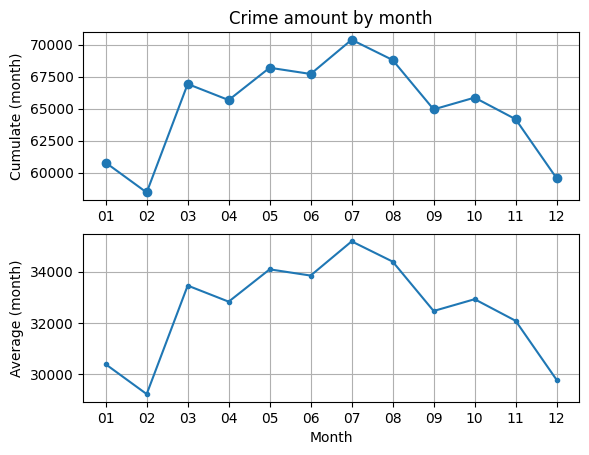

In [36]:
# Plot visualisations

import matplotlib.pyplot as plt
import numpy as np

y = monthArray
t = monthTotalArray
a = monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by month')
plt.ylabel('Cumulate (month)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Month')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")
plt.show()

In [38]:
# Create dataframe to retrieve information by year (total and average)
yearlyCrimeAmount = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
tbl_UKCrimes2 group by substring(Month, 0, 4)")

In [39]:
yearlyCrimeAmount
yearlyCrimeAmount.show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2022|392615|32717.916666666668|
|2021|388755|          32396.25|
+----+------+------------------+



In [40]:
# Register the yearly data in a temp table and show the contents
yearlyCrimeAmount.registerTempTable("yearlyCrimeAmount")
sqlContext.sql("select * from yearlyCrimeAmount").show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2022|392615|32717.916666666668|
|2021|388755|          32396.25|
+----+------+------------------+



In [41]:
# Prepare variables for visualisations

totalArray = sqlContext.sql("select Total from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()

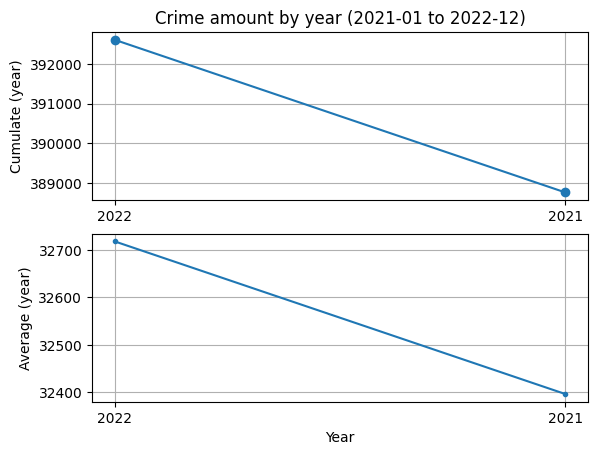

In [46]:
# Plot visualisations
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by year (2021-01 to 2022-12)')
plt.ylabel('Cumulate (year)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year')
plt.ylabel('Average (year)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")
plt.show()

In [48]:
sqlContext.sql("select Month, substring(Month, 0, 4) \
as Year, count(*) as Count from tbl_UKCrimes group by Month").show(10)

+-------+----+-----+
|  Month|Year|Count|
+-------+----+-----+
|2021-07|2021|35578|
|2022-04|2022|32914|
|2021-04|2021|32749|
|2022-06|2022|34009|
|2021-06|2021|33691|
|2022-08|2022|35624|
|2021-11|2021|32542|
|2021-03|2021|33072|
|2022-07|2022|34794|
|2021-10|2021|33343|
+-------+----+-----+
only showing top 10 rows



In [50]:
UKCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [51]:
# Create a Temp Table

UKCrime.registerTempTable("tbl_UKCrimeTypes")

In [54]:
# Crime Types per year/month

CrimeTypes = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year,\
count(*) as Count from tbl_UKCrimeTypes group by Month, Crime_type")

CrimeTypes.show()

+--------------------+-------+----+-----+
|          Crime_type|  Month|Year|Count|
+--------------------+-------+----+-----+
|Anti-social behav...|2022-03|2022| 4207|
|Anti-social behav...|2021-10|2021| 4433|
|Anti-social behav...|2021-04|2021| 6204|
|Possession of wea...|2021-08|2021|  258|
|             Robbery|2021-05|2021|  212|
|Possession of wea...|2022-05|2022|  279|
|Criminal damage a...|2021-03|2021| 2838|
|            Burglary|2021-12|2021| 1198|
|               Drugs|2021-07|2021|  781|
|       Bicycle theft|2021-11|2021|  314|
|Criminal damage a...|2022-07|2022| 3265|
|Violence and sexu...|2021-04|2021|13055|
|Violence and sexu...|2021-07|2021|14407|
|             Robbery|2021-07|2021|  223|
|Possession of wea...|2021-06|2021|  231|
|Criminal damage a...|2022-08|2022| 3421|
|Possession of wea...|2021-07|2021|  267|
|        Public order|2021-05|2021| 2684|
|            Burglary|2022-07|2022| 1294|
|Theft from the pe...|2022-05|2022|  192|
+--------------------+-------+----

In [56]:
# Explore Crime Types per year/month

CrimeTypesGeo = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year, Latitude, Longitude, \
count(*) as Count from tbl_UKCrimeTypes group by Month, \
Crime_type, Latitude, Longitude")

CrimeTypesGeo.show()

+--------------------+-------+----+---------+---------+-----+
|          Crime_type|  Month|Year| Latitude|Longitude|Count|
+--------------------+-------+----+---------+---------+-----+
|Anti-social behav...|2021-07|2021|51.137792| 0.880676|    1|
|Anti-social behav...|2021-07|2021| 51.14464| 0.876184|    2|
|       Vehicle crime|2021-07|2021|51.126541| 0.857192|    3|
|            Burglary|2021-07|2021|51.066994| 0.688334|    1|
|Anti-social behav...|2021-07|2021|51.366671| 1.129463|    1|
|Violence and sexu...|2021-07|2021|51.362385| 1.126944|    1|
|Violence and sexu...|2021-07|2021|51.361364| 1.050038|    1|
|Violence and sexu...|2021-07|2021|51.289979| 1.101563|    2|
|               Drugs|2021-07|2021|51.451639| 0.212676|    1|
|Anti-social behav...|2021-07|2021|51.453499| 0.210391|    1|
|         Other theft|2021-07|2021|51.444919| 0.214236|    2|
|Anti-social behav...|2021-07|2021|51.283735| 1.337879|    1|
|         Other theft|2021-07|2021|51.166918| 1.295609|    1|
|       

In [57]:
# Explore Crime Types per location for the period year/month

CrimeTypesLoc = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year, Location, \
count(*) as Count from tbl_UKCrimeTypes group by Month, \
Crime_type, Location")

CrimeTypesLoc.show()

+--------------------+-------+----+--------------------+-----+
|          Crime_type|  Month|Year|            Location|Count|
+--------------------+-------+----+--------------------+-----+
|Violence and sexu...|2021-07|2021|On or near Shotte...|    2|
|Anti-social behav...|2021-07|2021|On or near Friesi...|    2|
|Violence and sexu...|2021-07|2021|On or near Alfred...|    2|
|         Other theft|2021-07|2021|On or near Church...|    2|
|Anti-social behav...|2021-07|2021|On or near Chiche...|    8|
|Criminal damage a...|2021-07|2021|On or near Hadlei...|    1|
|        Public order|2021-07|2021|On or near Willow...|    1|
|               Drugs|2021-07|2021|On or near Windmi...|    1|
|               Drugs|2021-07|2021|On or near Tower ...|    1|
|       Vehicle crime|2021-07|2021|On or near Heathe...|    1|
|         Other crime|2021-07|2021|On or near Acacia...|    1|
|Criminal damage a...|2021-07|2021|On or near Bowlin...|    2|
|         Other crime|2021-07|2021|On or near St Geo...

In [5]:
#Create a dataFrame for Kent

KentCrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/kent-street/*street.csv")